This notebook provides an EDA informing data preprocessing steps and stationarity testing for the SportsCast data.

### Default Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pdb on
import pdb

Automatic pdb calling has been turned ON


In [ ]:
!pip install pmdarima
!pip install gluonts
!pip install mxnet

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
import pmdarima as pm
import copy
from IPython.display import Image
from scipy.ndimage.interpolation import shift

In [ ]:
import pandas as pd
from pandas.io.json import json_normalize
import pickle

In [ ]:
import json, itertools, os
import mxnet as mx
from mxnet import gluon
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from sklearn import preprocessing
from pathlib import Path

In [ ]:
!cp "/content/drive/My Drive/Project/glnts.py" .
!cp "/content/drive/My Drive/Project/api.py" .
!cp "/content/drive/My Drive/Project/ARIMA.py" .
!cp "/content/drive/My Drive/Project/Model.py" .
!cp "/content/drive/My Drive/Project/DataLoading.py" .

In [ ]:
import glnts
import api
import ARIMA, Model
import DataLoading

In [ ]:
PATH = '/content/drive/My Drive/Project'

In [ ]:
DATA_PATH = PATH + "/Data/Inputs/full_dataset_4_seasons.csv"
ROSTER_PATH = PATH + "/Data/Inputs/full_roster_4_seasons.csv"
RESULT_PATH = PATH+"/Data/Outputs/DeepAR/deepar_20192020_results_unit_s_ne50_lr1e-3_bs64_nl3_cl3.p"

In [ ]:
MODEL_DIR = PATH + "/Data/Models"
RESULT_DIR = PATH + "/Data/Outputs"

In [ ]:
def load_csv(path='../../data/input/full_dataset_4_seasons.csv'):
    data = pd.read_csv(path)
    return data

### Ingest Data

We ingest data for a given player (Taylor Hall) on which to perform the EDA and test data stationarity.

In [ ]:
data = copy.deepcopy(load_csv(DATA_PATH))
full_roster = load_csv(ROSTER_PATH)
data = DataLoading.preprocessing(data)

In [ ]:
subset_data = data[(data['name']=='Taylor Hall')]

In [ ]:
from DataLoading import load_data_listDS

ret = load_data_listDS(data=subset_data,roster=data,full_save_dir=RESULT_DIR, boolSplitTrainTest=True, \
                      use_exog_feat=False, boolTransformed=False, boolSave=False, \
                      column_list = ['date', 'name', 'gameNumber', 'cumStatpoints'], stand=False, \
                      scale=True, index='date',feature='cumStatpoints',forecast_from='2018-10-03', \
                       transform = 'none')

if ret is not None:
    train_list_ds, test_list_ds = ret

In [ ]:
player_train_labels, features_trn = Model.Model.decomposeListDS_dict(train_list_ds.list_data[0],use_exog_feats=True)
player_test_labels, features_test = Model.Model.decomposeListDS_dict(test_list_ds.list_data[0],use_exog_feats=True)

This provides us with raw training and testing data. We will use just the training data to train the models and observe residuals.

### EDA

#### Preprocess for EDA

We first preprocess the data by taking first differences.

In [ ]:
train_df,test_df = pd.DataFrame({'cumStatPoints':player_train_labels}),pd.DataFrame({'cumStatPoints':player_test_labels})

In [ ]:
def difference(df:pd.DataFrame,periods=1):
  return df.diff(periods=periods).dropna()

In [ ]:
def detrend_linear(arr:np.ndarray):
  return arr.reshape(-1,) - np.linspace(0,len(arr),len(arr))

In [ ]:
def difference_detrend(df:pd.DataFrame,periods=1):
  diff = difference(df,periods=periods)
  return diff - np.mean(diff)

In [ ]:
train_diff_df,test_diff_df = difference(train_df,periods=1),difference(test_df,periods=1)

In [ ]:
train_detrend_arr,test_detrend_arr = difference_detrend(train_df),difference_detrend(test_df)

Text(0.5, 1.0, 'Sample player time series showing error in points')

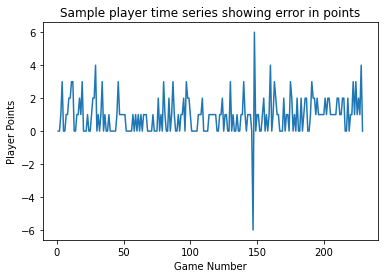

In [ ]:
plt.plot(train_diff_df)
plt.xlabel('Game Number')
plt.ylabel('Player Points')
plt.title('Sample player time series showing error in points')

In [ ]:
preproc_data = abs(train_diff_df) #Take the abs value to correct error

Text(0.5, 1.0, 'Player points after differencing - sample')

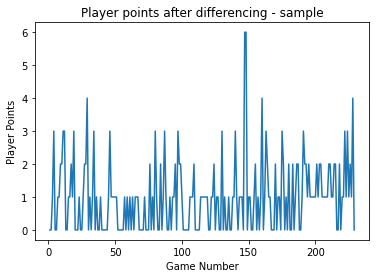

In [ ]:
plt.plot(preproc_data)
plt.xlabel('Game Number')
plt.ylabel('Player Points')
plt.title('Player points after differencing - sample')

This shows the preprocessed data does not have a clear trend or seasonality.

### EDA - Nonstationary Data

We first show that the timeseries for a given player is non-stationary in the whole.

#### Test stationarity

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries,boolVerbose=True):
    if boolVerbose:
        print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags=None)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    if boolVerbose:
        print (kpss_output)
    return kpsstest[1] #Return p-value

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries,boolVerbose=True):
		result = adfuller(timeseries)
		if boolVerbose:
				print('ADF Statistic: %f' % result[0])
				print('p-value: %f' % result[1])
				print('Critical Values:')
				for key, value in result[4].items():
					print('\t%s: %.3f' % (key, value))
		return result[1] #Return p-value

In [ ]:
adf_test(preproc_data)

ADF Statistic: -2.683889
p-value: 0.076868
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574


0.07686789985318682

In [ ]:
kpss_test(preproc_data)

Results of KPSS Test:
Test Statistic            0.573711
p-value                   0.025065
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


0.025065113864861606

This is not stationary according to the KPSS Test (for p=0.05), so we consider it non-stationary.




#### Compare stationarity without vs with scaling

 

1.   Without: see above
2.   With: see below



In [ ]:
from sklearn import preprocessing

def assemble_target(data, feature='cumStatpoints', stand=False, scale=True):
    assert len(data)>0, "Missing data"
    meta_dict = {}
    if not stand and not scale:
        target = data
    else:
        target = data.values.reshape(-1, 1)
        if stand:
            standardizer = preprocessing.StandardScaler()
            target = standardizer.fit_transform(target)
            meta_dict['mean'] = standardizer.mean_
            meta_dict['std'] = standardizer.scale_
        if scale:
            scaler = preprocessing.MinMaxScaler()
            target = scaler.fit_transform(target)
            meta_dict['min'] = scaler.min_
            meta_dict['scale'] = scaler.scale_
        target = target.tolist()
        # print(len(target))
        target = list(itertools.chain.from_iterable(target))
    return target, meta_dict

In [ ]:
scaled_target, meta_dict = assemble_target(preproc_data, feature='cumStatpoints', stand=True, scale=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(scaled_target)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.683889
p-value: 0.076868
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574


In [ ]:
kpss_test(scaled_target)

Results of KPSS Test:
Test Statistic            0.573711
p-value                   0.025065
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


0.025065113864861956

No difference, so no impact on stationarity.

Text(0.5, 1.0, 'ACF Showing Non-Stationarity')

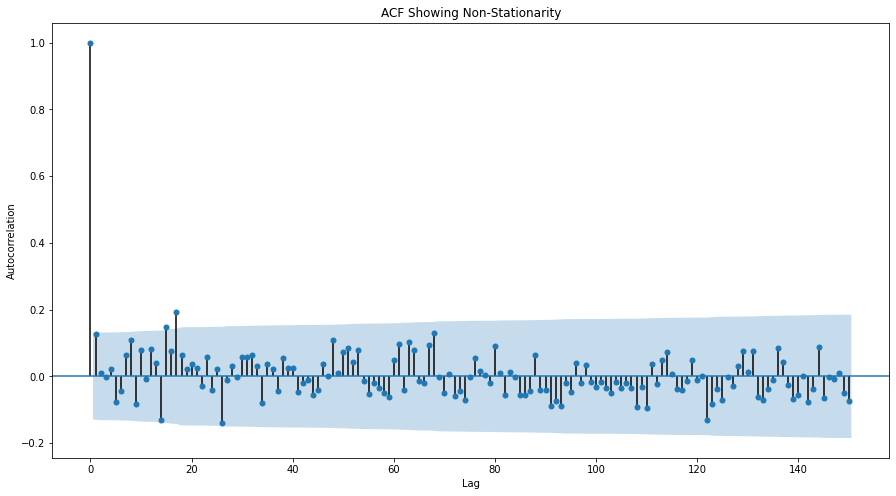

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(preproc_data,lags=150)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF Showing Non-Stationarity')

This ACF shows signifcant autocorrelation at high lags, so likely not stationary.

#### Fit model to non-stationary data

In [ ]:
X = preproc_data
#X = scaled_targets

In [ ]:
model_list =pm.auto_arima(X, exogenous=None,
                          start_p=0, max_p=10, start_q=0, max_q=10, max_order=30, max_d=10, m=82,
                          start_P=0, max_P=10, start_Q=0, max_Q=10,
                          seasonal=True, stationary=False, information_criterion='aic', test='kpss', stepwise=True, trace=False,
                          suppress_warnings=False,
                          out_of_sample_size= int(0.1*len(X)), scoring='mae', return_valid_fits=False, disp=True,
                          enforce_invertibility=True,enforce_stationarity=True)

In [ ]:
model_list

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=22,
      scoring='mae', scoring_args=None, seasonal_order=(0, 0, 1, 82),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [ ]:
model_list.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  229
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 82)   Log Likelihood                -338.805
Date:                            Sun, 19 Jul 2020   AIC                            685.611
Time:                                    00:56:49   BIC                            699.328
Sample:                                         0   HQIC                           691.145
                                            - 229                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.002      1.701      0.089      -0.000       0.006
ma.L1         -0.9998      1.140     -0.877      0.381      -3.235       1.235
ma.S.L82      -0.0575      0.100     -0.573      0.567      -0.254       0.139
sigma2         1.1140      1.291      0.863      0.388      -1.416       3.644
===================================================================================
Ljung-Box (Q):                       47.40   Jarque-Bera (JB):               218.67
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             1.53
Prob(H) (two-sided):                  0.78   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plotting the results (in-sample prediction vs targets) shows that the model fails with non-stationary data

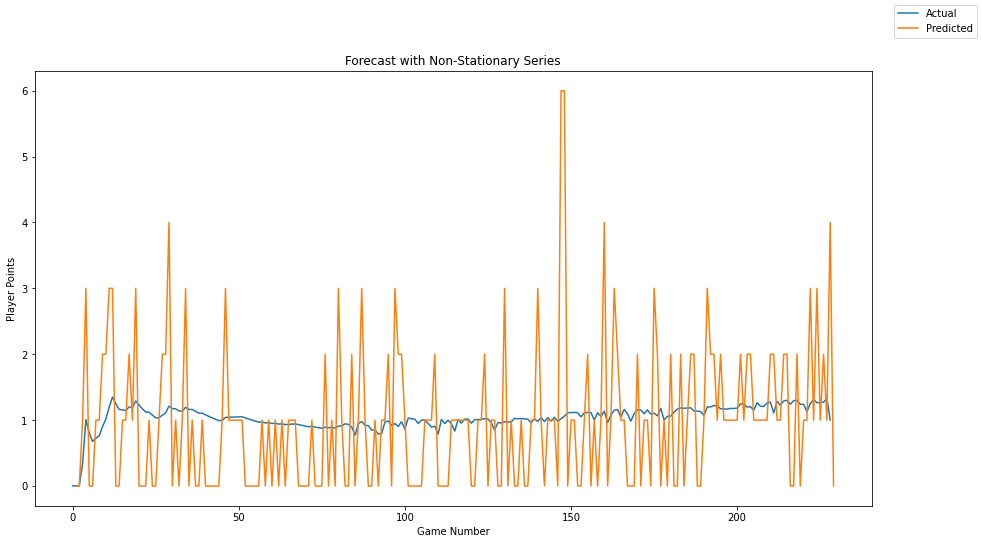

In [ ]:
plt.plot(model_list.predict_in_sample())
plt.plot(X)
plt.xlabel('Game Number')
plt.ylabel('Player Points')
plt.title('Forecast with Non-Stationary Series')
plt.figlegend(labels=('Actual','Predicted'))

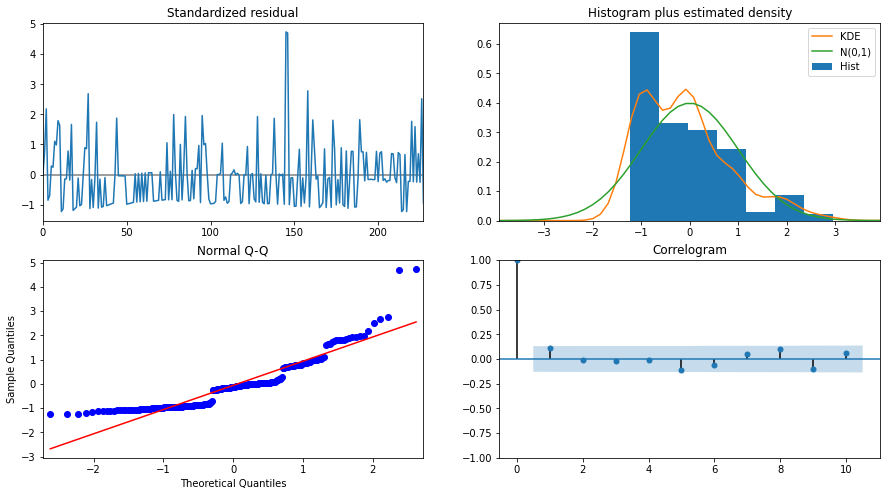

In [ ]:
plt.rcParams['figure.figsize'] = [15, 8]
ret = model_list.plot_diagnostics()

The correlogram in the diagnostics above shows significant correlation in residuals at the p=0.05 level.

### EDA - Stationary Data

We now extract batches of the time series that are locally stationary, and verify their stationarity.

#### Determine local stationarity

##### Test stationarity for a locale

We will determine the optimal forecasting duration so that the process is locally stationary

In [ ]:
#To batch data with possible remainder

def batch_array(iterable, n=1):
    totLen = len(iterable)
    for ndx in range(0, totLen, n):
        yield iterable[ndx:min(ndx + n, totLen)]

In [ ]:
opt_pval_kpss = 0
opt_pval_adf = 0
opt_tot_pval = np.inf
opt_dur = 0

import pdb

for loc_dur in range(4,100):
    ave_pval_kpss = 0; ave_pval_adf = 0;
    num_durs = 0;
    for time_loc in batch_array(preproc_data,loc_dur):
        try:
            kpss_val, adf_val = kpss_test(timeseries=time_loc,boolVerbose=False),adf_test(timeseries=time_loc,boolVerbose=False)
            if  not (kpss_val>0) or not (adf_val>0):
                continue
            ave_pval_kpss = ave_pval_kpss + np.float64(kpss_val)
            ave_pval_adf = ave_pval_adf + np.float64(adf_val)
        except ValueError as err:
            print(f'Error for loc_dur:{err}')
            continue
        num_durs = num_durs + 1

    ave_pval_kpss = ave_pval_kpss/num_durs
    ave_pval_adf = ave_pval_adf/num_durs
    tot_pval = ave_pval_adf - ave_pval_kpss

    if opt_tot_pval > tot_pval:
        opt_tot_pval = tot_pval
        opt_pval_kpss = ave_pval_kpss
        opt_pval_adf = ave_pval_adf
        opt_dur = loc_dur

In [ ]:
print(f'This shows that the optimal forecasting duration for stationarity is {opt_dur}')

This shows that the optimal forecasting duration for stationarity is 31


#### Select stationary subset

In [ ]:
stat_preproc_data = preproc_data[:opt_dur]

#### Test whether random walk

After attempting to stationarize, we verify that it is not a random walk by checking the ACF.

Text(0.5, 1.0, 'ACF showing data is not a random walk')

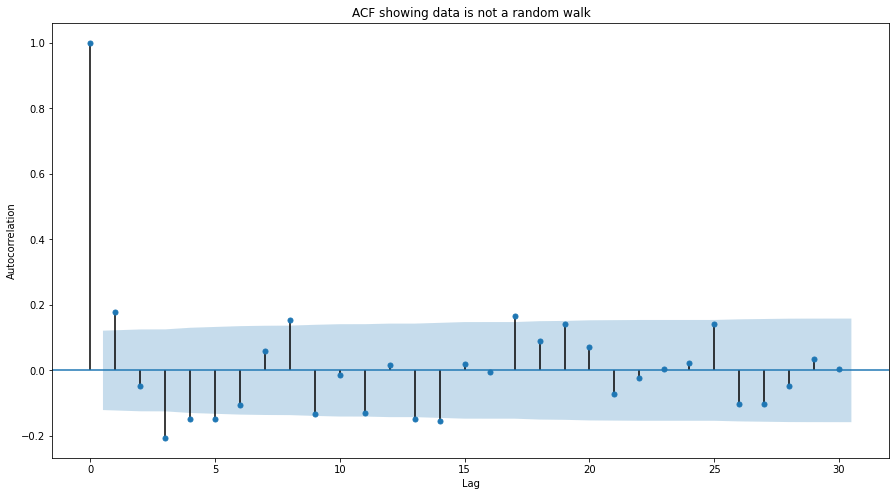

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

ret=plot_acf(stat_preproc_data,lags=min(100,len(stat_preproc_data)-1),alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF showing data is not a random walk')

As per [this resource](https://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/), some lags are significant at the p=0.05 level so the process is not a random walk.

#### Fit model to stationary data

In [ ]:
X = stat_preproc_data
#X = scaled_targets

In [ ]:
model =pm.auto_arima(X, exogenous=None,
                          start_p=0, max_p=10, start_q=0, max_q=10, max_order=30, max_d=10, m=3,
                          start_P=0, max_P=10, start_Q=0, max_Q=10,
                          seasonal=True, stationary=False, information_criterion='aic', test='kpss', stepwise=True, trace=False,
                          suppress_warnings=False,
                          out_of_sample_size= int(0.3*len(X)), scoring='mae', return_valid_fits=False, disp=True,
                          enforce_invertibility=True,enforce_stationarity=True)

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                   
====================================================================================
Dep. Variable:                            y   No. Observations:                   31
Model:             SARIMAX(0, 0, [1, 2], 3)   Log Likelihood                 -44.889
Date:                      Sun, 19 Jul 2020   AIC                             97.779
Time:                              01:53:02   BIC                            103.515
Sample:                                   0   HQIC                            99.649
                                       - 31                                         
Covariance Type:                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1444      0.068     16.754      0.000       1.011       1.278
ma.S.L3       -0.7235    220.862     -0.003      0.997    -433.604     432.158
ma.S.L6       -0.2763     61.159     -0.005      0.996    -120.146     119.594
sigma2         0.8791    194.223      0.005      0.996    -379.790     381.549
===================================================================================
Ljung-Box (Q):                       21.73   Jarque-Bera (JB):                 2.11
Prob(Q):                              0.86   Prob(JB):                         0.35
Heteroskedasticity (H):               1.18   Skew:                             0.56
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plotting the results (in-sample prediction vs targets) shows that the model works much better for locally stationary data

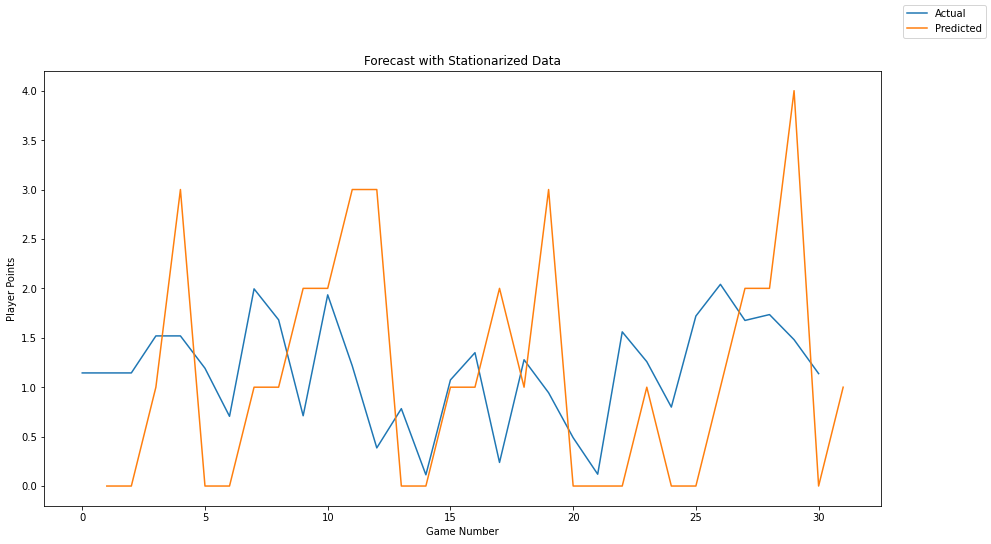

In [ ]:
plt.plot(model.predict_in_sample())
plt.plot(X)
plt.xlabel('Game Number')
plt.ylabel('Player Points')
plt.title('Forecast with Stationarized Data')
plt.figlegend(labels=('Actual','Predicted'))

Also plot diagnostics

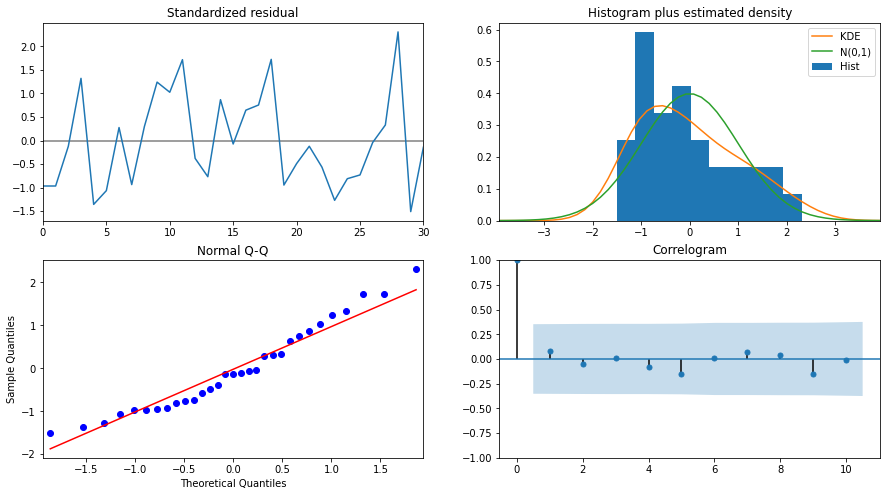

In [ ]:
plt.rcParams['figure.figsize'] = [15, 8]
ret = model.plot_diagnostics()

The lack of collection in errors on the correlogram suggests the data is homoscedastic, as we will test below.

#### Calculate errors

In [ ]:
residuals = model.resid()

In [ ]:
residuals_df = pd.DataFrame({"Resid":residuals})

In [ ]:
def calculate_errors(residuals):
    """ Calculates errors based on residuals """
    num_residuals = len(residuals)
    mfe = (residuals.sum() / num_residuals).tolist()[0]
    mae = (residuals.abs().sum() / num_residuals).tolist()[0]
    rmse = (residuals.pow(2).sum().pow(0.5)).tolist()[0]
    residuals = residuals.values
    residuals = [value.item() for value in residuals]
    return mfe, mae, rmse

def calculate_test_residuals(prediction_array, test_data):
    """ Calculates test residuals based on prediction and test data """
    prediction_array = prediction_array.reshape(len(test_data), 1)
    test_data = test_data.values
    residuals = np.subtract(test_data, prediction_array)
    residuals = residuals.tolist()
    residuals = pd.DataFrame(residuals)
    return residuals

def diffN(arr1,N):
    assert N>0, "Invalid difference!"
    f = lambda arr,i,n : 0 if (i+n+1)>len(arr) else arr[i+n]-arr[i]
    diff_arr = np.zeros(len(arr1))
    for j in range(len(arr1)):
        diff_arr[j] = f(arr1,j,N)
    return diff_arr

def calculate_errors_trackingSig(target_data, prediction_array=None, residuals=None, mase_forecast=1):
    try:
        if residuals is None and prediction_array is not None:
            residuals = calculate_test_residuals(prediction_array,target_data)
        elif prediction_array is None and residuals is not None:
            pass
        elif prediction_array is None and residuals is None:
            raise ValueError("Missing both prediction and residuals!")
        else:
            raise ValueError("Don't specify both prediction and residuals!")

        assert len(residuals)>0, "Missing residuals"
        assert len(target_data)>1, "Missing targets or only one point"

        mfe, mae, rmse = calculate_errors(residuals)
        tracking = sum(residuals.values)[0]/mae
        assert np.isscalar(sum(residuals.values)[0]), f"Error with sum for tracking signal. Sum = {sum(residuals.values)}"
        assert np.isscalar(tracking), f"Error with tracking signal. Residuals={residuals}"

        targets = np.array([val[0] for val in target_data.values])
        assert len(targets.shape)==1, f"Error with target dims. Shape={targets.shape}"
        first_diff_targets = diffN(targets, mase_forecast)
        assert len(first_diff_targets)>0, f"First diff is absent. First diffs={first_diff_targets}"
        oneNorm_first_diff_targets = sum(np.absolute(first_diff_targets))
        if not np.isscalar(oneNorm_first_diff_targets):
            print(f'\nTargets: {targets}')
            print(f'\nFirst diffs targets: {first_diff_targets}')
            print(f'\nAbsolute value: {np.absolute(first_diff_targets)}')
            print(f'\nSum: {oneNorm_first_diff_targets}')
            raise ValueError("Error with sum for mase")
        mean_first_diff_targets = oneNorm_first_diff_targets/len(first_diff_targets)
        mase = mae/mean_first_diff_targets
    except AssertionError as err:
        print(f"Error in calculating resids/tracking: {err}")
        return None 
    except ValueError as err:
        print(f"Error in calculating resids/tracking: {err}")
        return None
    return mfe, mae, rmse, mase, tracking, residuals

In [ ]:
ret = calculate_errors_trackingSig(target_data=X, residuals=residuals_df, mase_forecast=1)

if ret is not None:
  mfe, mae, rmse, mase, trackSig, residuals = ret
else:
  print('Error')

In [ ]:
print(f'The MASE error of this model is: {mase:.2f}')

The MASE error of this model is: 0.86


This shows much lower errors after stationarizing.

#### Test homoscedasticity after fitting

We test the residuals from fitting using the Box-Ljung test.

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

df = acorr_ljungbox(residuals,lags=10,period=3,return_df=True)
df.columns = ['Test Statistics','P-Values']
df

,Test Statistics,P-Values
1,0.286602,0.592406
2,0.416949,0.811822
3,0.430611,0.933849
4,0.622975,0.960477
5,1.343102,0.930435
6,1.344897,0.969124


Since p>0.05 for these lags, the null hypothesis (no autocorrelation in residuals) is not rejected. This confirms data is now homoscedastic.